In [6]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import tensorflow as tf
from matplotlib import pyplot as plt
#from sklearn.model_selection import train_test_split
 
tf.logging.set_verbosity(tf.logging.INFO)
 
tf.logging.log(tf.logging.INFO, "TensorFlow version " + tf.__version__)
 
DATA_PATH = 'customers_timeseries_updated.csv'
 
df = pd.read_csv(DATA_PATH,index_col=6)
print(df.head())

#only using required columns for modelling
df = df[['client_debtor_number','fv_cost']]
# number of unique customers in the data
print("number of unique customers",len(df['client_debtor_number'].unique()))

# subsetting one customer data from the set
# 1015193,7370830
df_1015130 = df[df['client_debtor_number'] == 1015193]
#del df_1015130['client_debtor_number']

df_1015130.drop(['client_debtor_number'],1, inplace=True)



INFO:tensorflow:TensorFlow version 1.11.0
            client_debtor_number client_document_date  \
dates                                                   
10/07/2010               1015193                  NaT   
11/07/2010               1015193                  NaT   
12/07/2010               1015193                  NaT   
13/07/2010               1015193                  NaT   
14/07/2010               1015193                  NaT   

            client_unique_document_no close_date collection_comments  \
dates                                                                  
10/07/2010                        NaN        NaT                 NaN   
11/07/2010                        NaN        NaT                 NaN   
12/07/2010                        NaN        NaT                 NaN   
13/07/2010                        NaN        NaT                 NaN   
14/07/2010                        NaN        NaT                 NaN   

           converted_currency_amount disputed_final d

/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/anusha/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
def scale_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
 
    df['fv_cost'] = min_max_scaler.fit_transform(df.fv_cost.values.reshape(-1, 1))
    return df
 
df = scale_data(df_1015130.copy())


In [8]:
df = np.array(df.fv_cost.values)

In [9]:
# Divide Lsit into chunks of length n
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

print (list(chunks(df,32)))

[array([0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741]), array([0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13415741, 0.13415741,
       0.13415741, 0.13415741, 0.13415741, 0.13309406, 0.13316013,
       0.13322621, 0.1332923 ]), array([0.13294349, 0.13302388, 0.13310427, 0.13318468, 0.13364667,
       0.13367624, 0.12728706, 0.12564496, 0.12631237, 0.12737

In [5]:
# dividing data into batch _size:
def myGenerator():
   #
   # y_train = np_utils.to_categorical(y_train,10)
    X_train = X_train.reshape(X_train.shape[0], 1, irows, icols)
    X_test = X_test.reshape(X_test.shape[0], 1, irows, icols)
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    while 1:
        for i in range(1875): # 1875 * 32 = 60000 -> # of training samples
            if i%125==0:
                print "i = " + str(i)
            yield X_train[i*32:(i+1)*32], y_train[i*32:(i+1)*32]
            



SyntaxError: invalid syntax (<ipython-input-5-86ca198eafab>, line 14)

In [15]:
SEQLEN = 2  # unrolled sequence length
BATCHSIZE = 37
DATA_SEQ_LEN = len(df)
train_split = 0.8

X = df
Y = np.roll(df, -1)
 

num_data= X.shape[0]
num_train  = int(train_split * num_data)
X_train = X[0:num_train]
Y_train = Y[0:num_train]
 
Y_test = Y[num_train:]
X_test = X[num_train:]

X_train = np.reshape(X_train, [-1, SEQLEN])
Y_train = np.reshape(Y_train, [-1, SEQLEN])
 
X_test = np.reshape(X_test, [-1, SEQLEN])
Y_test = np.reshape(Y_test, [-1, SEQLEN])
 
# If not repeated data will stop after 1 epoch 
def train_dataset():
    dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
    dataset = dataset.repeat()
    #dataset = dataset.shuffle(DATA_SEQ_LEN * 4 // SEQLEN)
    dataset = dataset.shuffle(SEQLEN)
    dataset = dataset.batch(BATCHSIZE)
    samples, labels = dataset.make_one_shot_iterator().get_next()
    return samples, labels
 
 
def eval_dataset():
    evaldataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    evaldataset = evaldataset.repeat(1)
    #evaldataset = evaldataset.repeat()
    evaldataset = evaldataset.batch(BATCHSIZE)
 
    samples, labels = evaldataset.make_one_shot_iterator().get_next()
    return samples, labels

In [16]:
RNN_CELLSIZE = 80
N_LAYERS = 2
DROPOUT_PKEEP = 0.7
 
def model_rnn_fn(features, labels, mode):
    
    X = tf.expand_dims(features, axis=2)
 
    batchsize = tf.shape(X)[0]
    seqlen = tf.shape(X)[1]
 
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(N_LAYERS)]
 
    cells[:-1] = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=DROPOUT_PKEEP) for cell in cells[:-1]]
    # a stacked RNN cell still works like an RNN cell
    cell = tf.nn.rnn_cell.MultiRNNCell(cells, state_is_tuple=False)
 
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, RNN_CELLSIZE*N_LAYERS]
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float64) #changed dtype from example as float32 doesn't work with my python
 
    #Yn = tf.cast(Yn,)
    Yn = tf.reshape(Yn, [batchsize * seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1)  # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1])  # Yr [BATCHSIZE, SEQLEN, 1]
 
    Yout = Yr[:, -1, :]  # Last output Yout [BATCHSIZE, 1]
 
    loss = train_op = None
    if mode != tf.estimator.ModeKeys.PREDICT:
        labels = tf.expand_dims(labels, axis=2)
        loss = tf.losses.mean_squared_error(Yr, labels)  # la  bels[BATCHSIZE, SEQLEN, 1]
        lr = 0.001
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
 
        train_op = tf.contrib.training.create_train_op(loss, optimizer)
 
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={"Yout": Yout},
        loss=loss,
        train_op=train_op
    )


In [17]:
training_config = tf.estimator.RunConfig(model_dir="./outputdir")
estimator = tf.estimator.Estimator(model_fn=model_rnn_fn, config=training_config)

INFO:tensorflow:Using config: {'_model_dir': './outputdir', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c3cc85f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [18]:
estimator.train(input_fn=train_dataset,steps=2000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./outputdir/model.ckpt.
INFO:tensorflow:loss = 0.018763626, step = 1
INFO:tensorflow:global_step/sec: 84.4624
INFO:tensorflow:loss = 0.012027883, step = 101 (1.185 sec)
INFO:tensorflow:global_step/sec: 158.705
INFO:tensorflow:loss = 0.00050754653, step = 201 (0.630 sec)
INFO:tensorflow:global_step/sec: 159.421
INFO:tensorflow:loss = 0.0034204556, step = 301 (0.627 sec)
INFO:tensorflow:global_step/sec: 166.417
INFO:tensorflow:loss = 3.2717424e-05, step = 401 (0.601 sec)
INFO:tensorflow:global_step/sec: 162.321
INFO:tensorflow:loss = 0.015793307, step = 501 (0.617 sec)
INFO:tensorflow:global_step/sec: 150.962
INFO:tensorflow:loss = 0.0013421506, step = 601 (0.663 sec)
INFO:tensorflow:global_step/sec: 158.125
I

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./outputdir/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


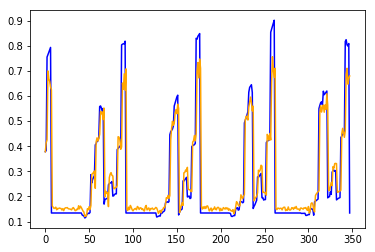

In [22]:
results = estimator.predict(eval_dataset)
 
Yout_ = [result["Yout"] for result in results]
 
actual = Y_test[:, -1]
 
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.plot(actual, label="Actual Values", color='blue')
plt.plot(Yout_, label="Predicted Values", color='orange', )
 
plt.show()